<a href="https://colab.research.google.com/github/ZeyuWu2001/Zeyu-Wu-Introduction/blob/Project-4/Project%204%20-%20Zeyu%20Wu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Zeyu Wu

Instructor: Kasey Zapatka

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load nhanes data
nhanes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project4/nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes), columns = nhanes.columns)

# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

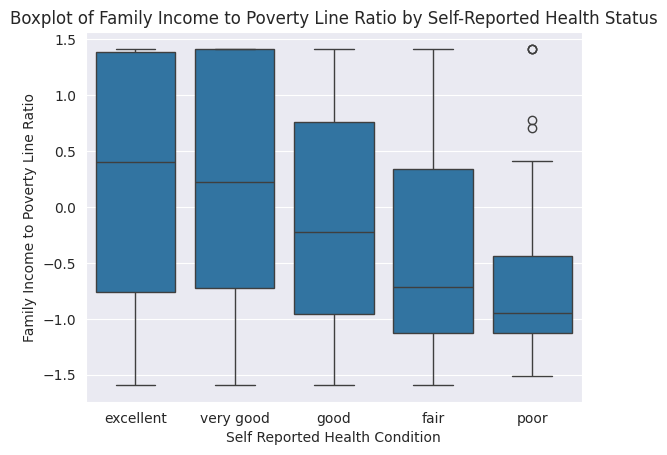

In [ ]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

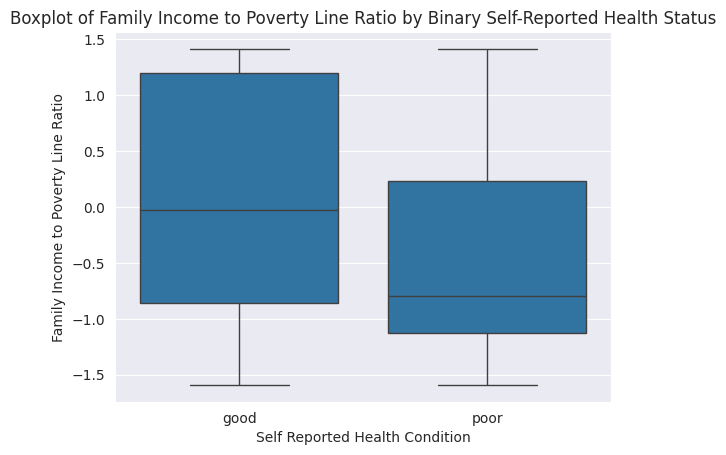

In [ ]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy.

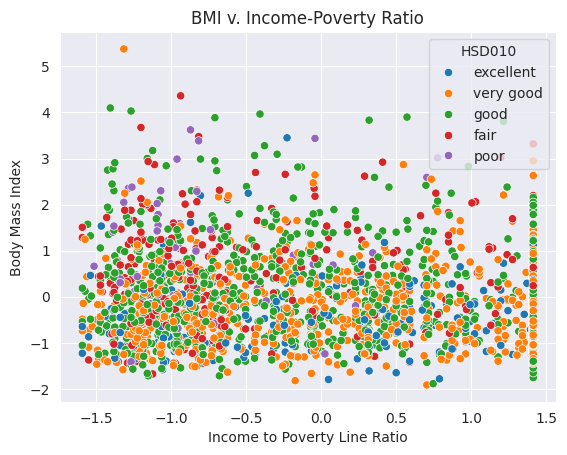

In [ ]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

In [ ]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

### Train PCA and Discuss Number of Components

In [ ]:
pca = PCA()
pca_fit = pca.fit(nhanes_scaled)

# Explained variance ratio for each component
explained_variance = pca_fit.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a DataFrame to display the explained variance and cumulative variance for each component
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance Ratio': explained_variance.cumsum()
})

print('Total PCs:', len(explained_variance))
explained_variance_df.head()

Total PCs: 241


,Principal Component,Explained Variance Ratio,Cumulative Variance Ratio
0,PC1,0.102020,0.102020
1,PC2,0.076230,0.178250
2,PC3,0.043712,0.221962
3,PC4,0.028822,0.250783
4,PC5,0.023571,0.274355


### Barplot of Components

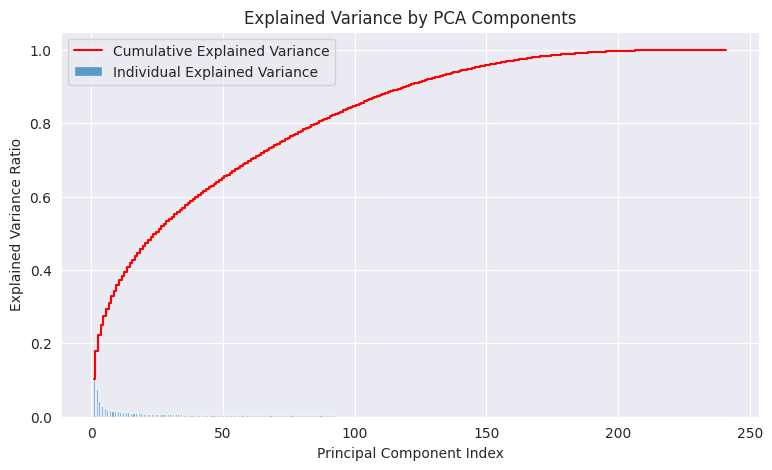

In [ ]:
# Barplot of Explained Variance
plt.figure(figsize=(9, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance) + 1), cumulative_variance, where='mid', label='Cumulative Explained Variance', color='red')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.legend()
plt.show()

### How many components will you use to fit a supervised learning model?

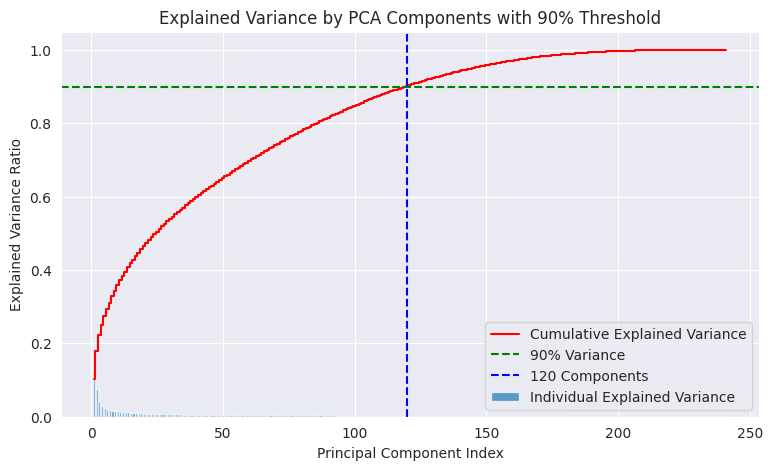

Number of components selected to retain 90% variance: 120 PCs


In [ ]:
# Re-plot the Barplot of Explained Variance with horizontal and vertical lines
plt.figure(figsize=(9, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative Explained Variance', color='red')

# Add a horizontal line at 90% cumulative variance
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Variance')

# Add a vertical line at the number of components that retain 90% variance
components_selected = (explained_variance.cumsum() >= 0.90).argmax() + 1
plt.axvline(x=components_selected, color='blue', linestyle='--', label=f'{components_selected} Components')

# Labels and Title
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components with 90% Threshold')
plt.legend()
plt.show()


# Choose the number of components to retain 90% variance
components_selected = (explained_variance.cumsum() >= 0.90).argmax() + 1
print(f"Number of components selected to retain 90% variance: {components_selected} PCs")

### 2D Scatterplot of the first two components

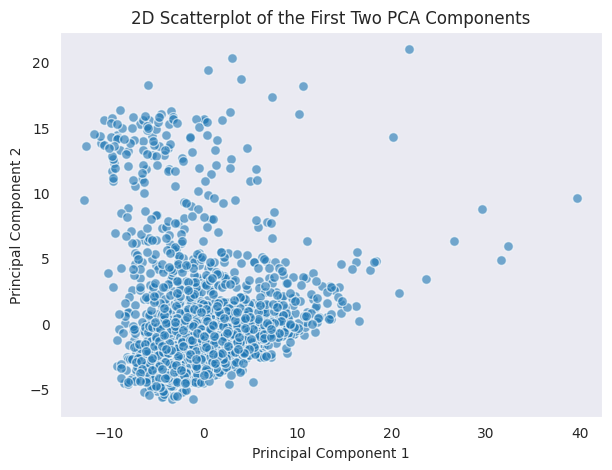

In [ ]:
pca_2d = PCA(n_components=2)
nhanes_pca_2d = pca_2d.fit_transform(nhanes_scaled)

plt.figure(figsize=(7, 5))
plt.scatter(nhanes_pca_2d[:, 0], nhanes_pca_2d[:, 1], alpha=0.6, edgecolors='w', s=50)
plt.title('2D Scatterplot of the First Two PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

The scatterplot of the first two principal components shows a dense cluster of points near the center, indicating that most of the data is tightly grouped in terms of variance captured by these components. A few points are scattered far from the center, which might suggest the presence of outliers or data points with unique characteristics.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

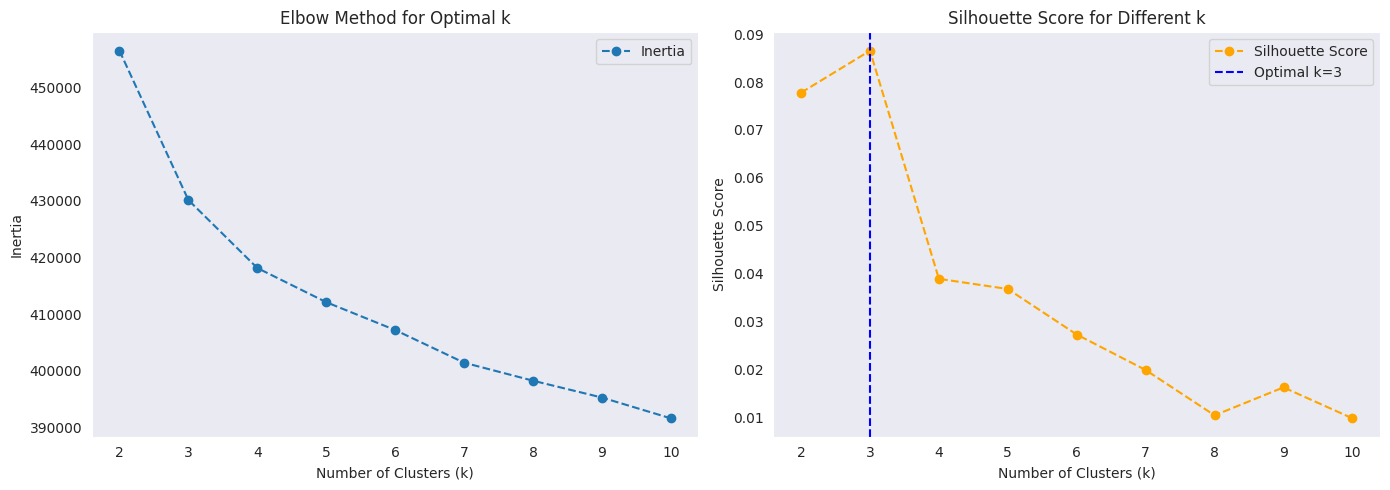

In [ ]:
inertia = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(nhanes_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(nhanes_scaled, cluster_labels))

# Plot Elbow Method and Silhouette Score side-by-side with a vertical line for k=3
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method plot
axes[0].plot(k_values, inertia, marker='o', linestyle='--', label='Inertia')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid()
axes[0].legend()

# Silhouette Score plot
axes[1].plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange', label='Silhouette Score')
axes[1].axvline(x=3, color='blue', linestyle='--', label='Optimal k=3')  # Add vertical line at k=3
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Different k')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

The Elbow Method plot (left) shows a noticeable "elbow" around k=4 or k=3, suggesting that 4 or 3 clusters might be a good choice for balancing inertia and the number of clusters. The Silhouette Score plot (right) indicates that k=3 provides the highest silhouette score, which measures the consistency and separation of the clusters.

### Cluster nhanes

In [ ]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(nhanes_scaled)

# Add cluster labels to the DataFrame for further analysis
nhanes_scaled['Cluster'] = clusters
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,Cluster
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,0
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,1
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,0
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,1


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

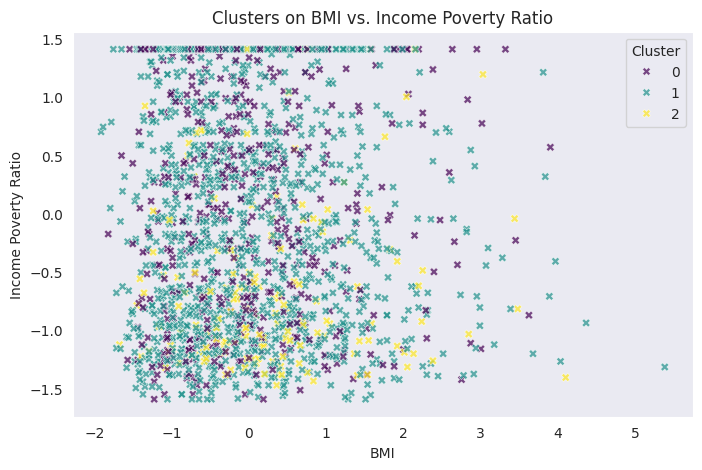

In [ ]:
bmi_col = "BMXBMI"
poverty_ratio_col = "INDFMPIR"

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=nhanes_scaled,
    x=bmi_col,
    y=poverty_ratio_col,
    hue='Cluster',
    palette='viridis',
    alpha=0.7,
    marker='X'  # Set marker to 'X'
)

plt.title('Clusters on BMI vs. Income Poverty Ratio')
plt.xlabel('BMI')
plt.ylabel('Income Poverty Ratio')
plt.legend(title='Cluster')
plt.grid()
plt.show()

The clusters displayed on the BMI vs. Income Poverty Ratio plot highlight three distinct groupings. While there is noticeable overlap between the clusters, certain regions of BMI and Income Poverty Ratio show dominance by specific clusters, suggesting variations in socioeconomic and health-related patterns within the dataset.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

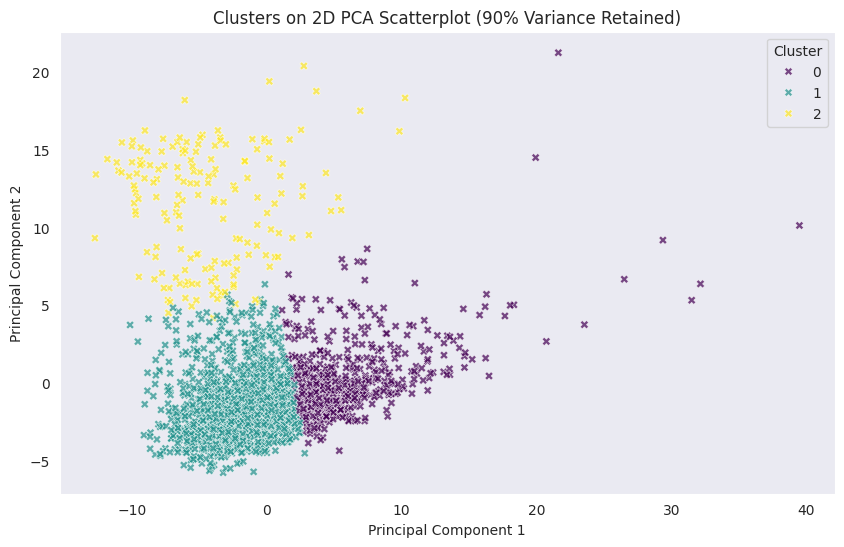

In [ ]:
# Retain 90% cumulated variance (Selected PCs)
pca_selected = PCA(n_components=components_selected)
pca_fit = pca_selected.fit_transform(nhanes_scaled)

# Retrain K-Means on selected PCs data (90% variance)
optimal_k = 3  # Based on previous silhouette score analysis
kmeans_pca_selected = KMeans(n_clusters=optimal_k, random_state=42)
clusters_pca_selected = kmeans_pca_selected.fit_predict(pca_fit)

# Create a DataFrame for PCA-transformed data with cluster labels
pca_transformed_df = pd.DataFrame(pca_fit, columns=[f'PC{i+1}' for i in range(components_selected)])
pca_transformed_df['Cluster'] = clusters_pca_selected

# Plot clusters on the 2D PCA scatterplot with 'X' markers
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_transformed_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    alpha=0.7,
    marker='X'  # Set marker to 'X'
)
plt.title('Clusters on 2D PCA Scatterplot (90% Variance Retained)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

Using the PCA results for clustering has led to more distinct separations in the 2D scatterplot of the first two principal components, compared to clustering directly on the original dataset. The clusters now appear better defined, with less overlap between groups, indicating that dimensionality reduction has enhanced the clustering performance by eliminating noise and irrelevant features.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
# partition data
y = hsd010 - 1  # Subtract 1 from all labels
X = nhanes_scaled

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
y.unique()

array([0, 1, 2, 3, 4])

In [ ]:
# load libraries
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

num_classes = len(np.unique(y))
# Convert target to categorical format for neural network
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [ ]:
# create neural network model
model = Sequential()

# Input and first hidden layer
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation='relu'))

# Second hidden layer
model.add(Dense(64, kernel_initializer='he_normal', activation='relu'))

# Output layer
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_original = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3411 - loss: 1.6808 - val_accuracy: 0.4031 - val_loss: 1.3331
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5576 - loss: 1.0752 - val_accuracy: 0.4070 - val_loss: 1.2981
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6569 - loss: 0.8756 - val_accuracy: 0.4283 - val_loss: 1.2799
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7509 - loss: 0.7366 - val_accuracy: 0.4419 - val_loss: 1.2856
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8134 - loss: 0.6145 - val_accuracy: 0.4729 - val_loss: 1.3405
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8529 - loss: 0.5236 - val_accuracy: 0.4554 - val_loss: 1.3600
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8972 - loss: 0.4277 - val_accuracy: 0.4496 - val_loss: 1.4175
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9316 - loss: 0.3551 - val_accuracy: 0.4516 - val_loss:

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Original Features Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.4380

Classification Report (Original Features Model):
               precision    recall  f1-score   support

           0       0.35      0.22      0.27        60
           1       0.45      0.45      0.45       174
           2       0.47      0.55      0.51       204
           3       0.35      0.28      0.31        69
           4       0.25      0.33      0.29         9

    accuracy                           0.44       516
   macro avg       0.37      0.37      0.36       516
weighted avg       0.43      0.44      0.43       516



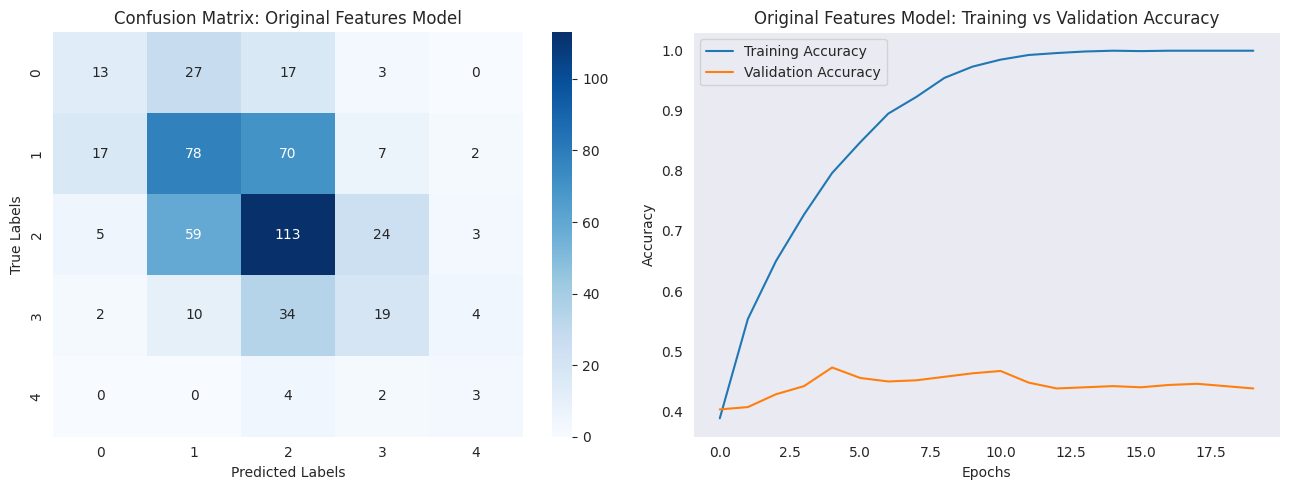

In [ ]:
# Predict using the trained model
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Convert predictions and true labels back from one-hot encoding
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

y_train_actual = np.argmax(y_train, axis=1)
y_test_actual = np.argmax(y_test, axis=1)

# Calculate accuracy
train_accuracy_original = accuracy_score(y_train_actual, y_pred_train)
test_accuracy_original = accuracy_score(y_test_actual, y_pred_test)

print("Original Features Model:")
print(f"Training Accuracy: {train_accuracy_original:.4f}")
print(f"Testing Accuracy: {test_accuracy_original:.4f}")

# Classification report and confusion matrix
print("\nClassification Report (Original Features Model):\n", classification_report(y_test_actual, y_pred_test))

# Confusion Matrix
conf_matrix_original = confusion_matrix(y_test_actual, y_pred_test)

# Subplots: Confusion Matrix + Accuracy Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(conf_matrix_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y), ax=axes[0])
axes[0].set_title("Confusion Matrix: Original Features Model")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Subplot 2: Training vs Validation Accuracy
axes[1].plot(history_original.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_original.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('Original Features Model: Training vs Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### Neural Network on Principal Components

In [ ]:
# Partition data
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(pca_fit, y, test_size=0.25, random_state=10)

# Adjust y_train and y_test (if not already adjusted)
pca_y_train = pca_y_train - pca_y_train.min()
pca_y_test = pca_y_test - pca_y_test.min()

# Convert labels to categorical format
num_classes = len(np.unique(pca_y_train))
pca_y_train = to_categorical(pca_y_train, num_classes=num_classes)
pca_y_test = to_categorical(pca_y_test, num_classes=num_classes)

# Create the neural network model
model_pca = Sequential()
model_pca.add(Dense(128, input_dim=pca_X_train.shape[1], kernel_initializer='he_normal', activation='relu'))
model_pca.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
model_pca.add(Dense(num_classes, kernel_initializer='glorot_uniform', activation='softmax'))

# Compile the model
model_pca.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_pca = model_pca.fit(pca_X_train, pca_y_train, validation_data=(pca_X_test, pca_y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3681 - loss: 1.6869 - val_accuracy: 0.3682 - val_loss: 1.5045
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5201 - loss: 1.1588 - val_accuracy: 0.3953 - val_loss: 1.3977
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6085 - loss: 1.0068 - val_accuracy: 0.4205 - val_loss: 1.3773
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6436 - loss: 0.8655 - val_accuracy: 0.4225 - val_loss: 1.3576
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7495 - loss: 0.7294 - val_accuracy: 0.4399 - val_loss: 1.3633
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7942 - loss: 0.6404 - val_accuracy: 0.4147 - val_loss: 1.3823
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8210 - loss: 0.5861 - val_accuracy: 0.4147 - val_loss: 1.4117
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.4983 - val_accuracy: 0.4341 - val_loss: 1.4620
Epo

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
PCA Features Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.4031

Classification Report (PCA Features Model):
               precision    recall  f1-score   support

           0       0.33      0.25      0.28        60
           1       0.39      0.43      0.41       174
           2       0.45      0.47      0.46       204
           3       0.35      0.32      0.33        69
           4       0.33      0.11      0.17         9

    accuracy                           0.40       516
   macro avg       0.37      0.32      0.33       516
weighted avg       0.40      0.40      0.40       516



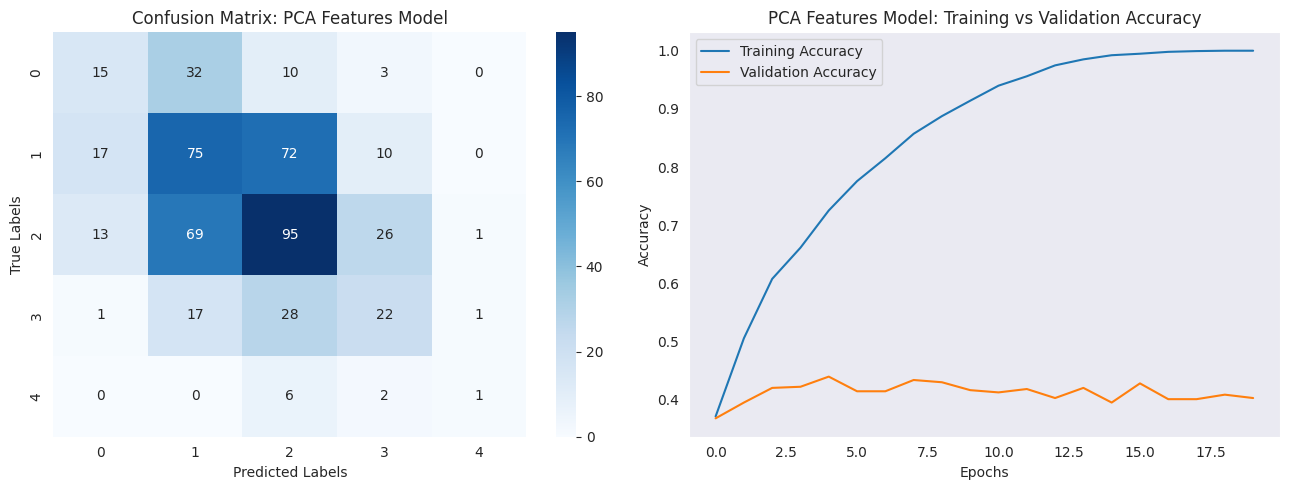

In [ ]:
# Predict using the trained model
y_pred_train_pca = model_pca.predict(pca_X_train)
y_pred_test_pca = model_pca.predict(pca_X_test)

# Convert predictions and true labels back from one-hot encoding
y_pred_train_pca = np.argmax(y_pred_train_pca, axis=1)
y_pred_test_pca = np.argmax(y_pred_test_pca, axis=1)

y_train_actual_pca = np.argmax(pca_y_train, axis=1)
y_test_actual_pca = np.argmax(pca_y_test, axis=1)

# Calculate accuracy
train_accuracy_pca = accuracy_score(y_train_actual_pca, y_pred_train_pca)
test_accuracy_pca = accuracy_score(y_test_actual_pca, y_pred_test_pca)

print("PCA Features Model:")
print(f"Training Accuracy: {train_accuracy_pca:.4f}")
print(f"Testing Accuracy: {test_accuracy_pca:.4f}")

# Classification report and confusion matrix
print("\nClassification Report (PCA Features Model):\n", classification_report(y_test_actual_pca, y_pred_test_pca))

# Confusion Matrix
conf_matrix_pca = confusion_matrix(y_test_actual_pca, y_pred_test_pca)

# Subplots: Confusion Matrix + Accuracy Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(conf_matrix_pca, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y), ax=axes[0])
axes[0].set_title("Confusion Matrix: PCA Features Model")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Subplot 2: Training vs Validation Accuracy
axes[1].plot(history_pca.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_pca.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('PCA Features Model: Training vs Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### Neural Network on Principal Components + Cluster Membership

In [ ]:
# Combine PCA-transformed data with cluster labels
pca_with_clusters = np.hstack([pca_fit, clusters_pca_selected.reshape(-1, 1)])

# Partition data
pca_clust_X_train, pca_clust_X_test, pca_clust_y_train, pca_clust_y_test = train_test_split(
    pca_with_clusters, y, test_size=0.25, random_state=10
)

# Adjust labels to start from 0
pca_clust_y_train = pca_clust_y_train - pca_clust_y_train.min()
pca_clust_y_test = pca_clust_y_test - pca_clust_y_test.min()

# Convert labels to categorical format
num_classes = len(np.unique(pca_clust_y_train))
pca_clust_y_train = to_categorical(pca_clust_y_train, num_classes=num_classes)
pca_clust_y_test = to_categorical(pca_clust_y_test, num_classes=num_classes)

# Create the neural network model
model_pca_clust = Sequential()
model_pca_clust.add(Dense(128, input_dim=pca_clust_X_train.shape[1], kernel_initializer='he_normal', activation='relu'))
model_pca_clust.add(Dense(64, kernel_initializer='he_normal', activation='relu'))
model_pca_clust.add(Dense(num_classes, kernel_initializer='glorot_uniform', activation='softmax'))

# Compile the model
model_pca_clust.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_pca_clust = model_pca_clust.fit(
    pca_clust_X_train, pca_clust_y_train,
    validation_data=(pca_clust_X_test, pca_clust_y_test),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3139 - loss: 1.8105 - val_accuracy: 0.3973 - val_loss: 1.4133
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5015 - loss: 1.2172 - val_accuracy: 0.4128 - val_loss: 1.3324
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5852 - loss: 1.0299 - val_accuracy: 0.4225 - val_loss: 1.3034
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6264 - loss: 0.9473 - val_accuracy: 0.4380 - val_loss: 1.2973
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6932 - loss: 0.8454 - val_accuracy: 0.4496 - val_loss: 1.3017
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7418 - loss: 0.7231 - val_accuracy: 0.4651 - val_loss: 1.3263
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7853 - loss: 0.6428 - val_accuracy: 0.4671 - val_loss: 1.3550
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8290 - loss: 0.5554 - val_accuracy: 0.4574 - val_loss: 1.3870
Epo

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
PCA + Clustering Features Model:
Training Accuracy: 1.0000
Testing Accuracy: 0.4651

Classification Report (PCA + Clustering Features Model):
               precision    recall  f1-score   support

           0       0.47      0.33      0.39        60
           1       0.46      0.53      0.49       174
           2       0.51      0.53      0.52       204
           3       0.36      0.28      0.31        69
           4       0.00      0.00      0.00         9

    accuracy                           0.47       516
   macro avg       0.36      0.33      0.34       516
weighted avg       0.46      0.47      0.46       516



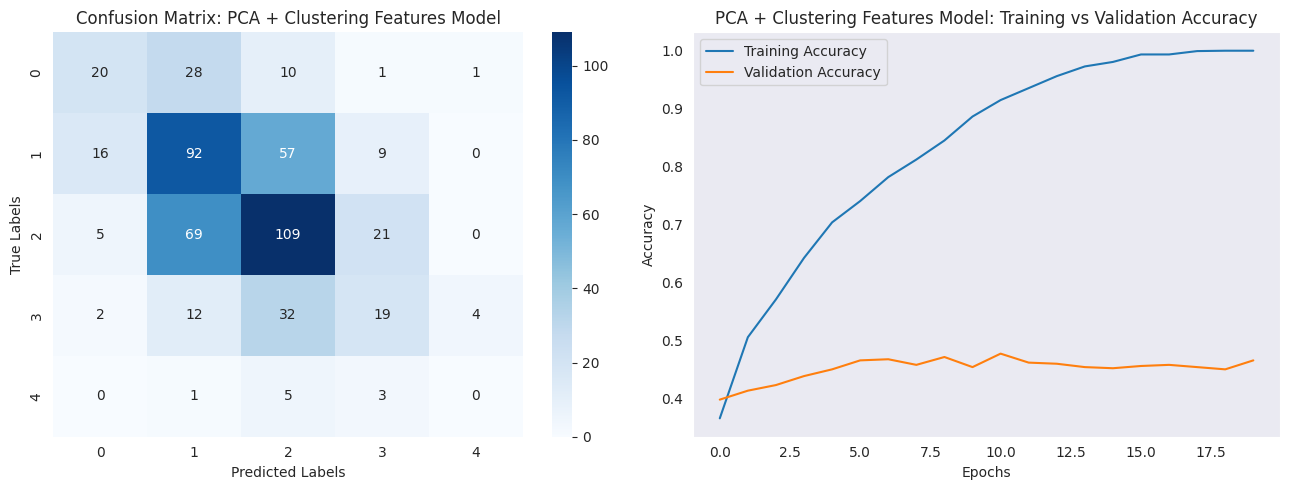

In [ ]:
# Predict using the trained model
y_pred_train_pca_clust = model_pca_clust.predict(pca_clust_X_train)
y_pred_test_pca_clust = model_pca_clust.predict(pca_clust_X_test)

# Convert predictions and true labels back from one-hot encoding
y_pred_train_pca_clust = np.argmax(y_pred_train_pca_clust, axis=1)
y_pred_test_pca_clust = np.argmax(y_pred_test_pca_clust, axis=1)

y_train_actual_pca_clust = np.argmax(pca_clust_y_train, axis=1)
y_test_actual_pca_clust = np.argmax(pca_clust_y_test, axis=1)

# Calculate accuracy
train_accuracy_pca_clust = accuracy_score(y_train_actual_pca_clust, y_pred_train_pca_clust)
test_accuracy_pca_clust = accuracy_score(y_test_actual_pca_clust, y_pred_test_pca_clust)

print("PCA + Clustering Features Model:")
print(f"Training Accuracy: {train_accuracy_pca_clust:.4f}")
print(f"Testing Accuracy: {test_accuracy_pca_clust:.4f}")

# Classification report and confusion matrix
print("\nClassification Report (PCA + Clustering Features Model):\n", classification_report(y_test_actual_pca_clust, y_pred_test_pca_clust))

# Confusion Matrix
conf_matrix_pca_clust = confusion_matrix(y_test_actual_pca_clust, y_pred_test_pca_clust)

# Subplots: Confusion Matrix + Accuracy Plot
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Subplot 1: Confusion Matrix
sns.heatmap(conf_matrix_pca_clust, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y), yticklabels=np.unique(y), ax=axes[0])
axes[0].set_title("Confusion Matrix: PCA + Clustering Features Model")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Subplot 2: Training vs Validation Accuracy
axes[1].plot(history_pca_clust.history['accuracy'], label='Training Accuracy')
axes[1].plot(history_pca_clust.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_title('PCA + Clustering Features Model: Training vs Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### Comparison of all three models

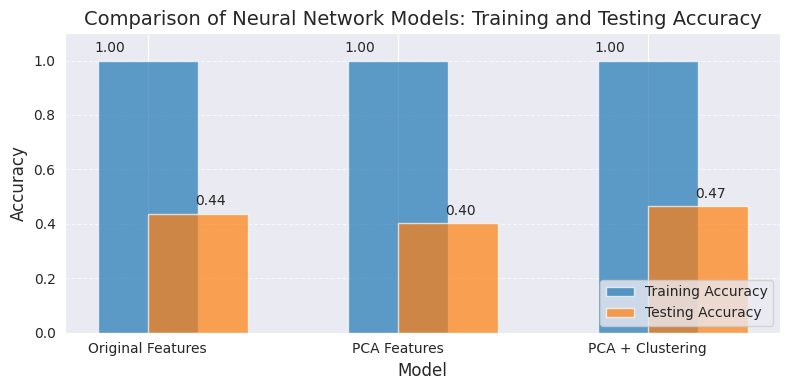

               Model  Training Accuracy  Testing Accuracy
0  Original Features                1.0          0.437984
1       PCA Features                1.0          0.403101
2   PCA + Clustering                1.0          0.465116


In [ ]:
comparison_data = {
    "Model": ["Original Features", "PCA Features", "PCA + Clustering"],
    "Training Accuracy": [train_accuracy_original, train_accuracy_pca, train_accuracy_pca_clust],
    "Testing Accuracy": [test_accuracy_original, test_accuracy_pca, test_accuracy_pca_clust]
}

# Convert to a DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Visualization of comparison
plt.figure(figsize=(8, 4))

# Bar plot for training accuracy
plt.bar(comparison_df["Model"], comparison_df["Training Accuracy"], alpha=0.7, label="Training Accuracy", width=0.4, align="center")

# Bar plot for testing accuracy
plt.bar(comparison_df["Model"], comparison_df["Testing Accuracy"], alpha=0.7, label="Testing Accuracy", width=0.4, align="edge")

# Add annotations for clarity
for idx, row in comparison_df.iterrows():
    plt.text(idx - 0.15, row["Training Accuracy"] + 0.02, f"{row['Training Accuracy']:.2f}", ha='center', va='bottom', fontsize=10)
    plt.text(idx + 0.25, row["Testing Accuracy"] + 0.02, f"{row['Testing Accuracy']:.2f}", ha='center', va='bottom', fontsize=10)

# Customize plot
plt.title("Comparison of Neural Network Models: Training and Testing Accuracy", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)  # Ensure enough space for annotations
plt.legend(loc="lower right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

# Display comparison DataFrame for reference
print(comparison_df)

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

Principal Component Analysis (PCA) and clustering serve distinct purposes in unsupervised learning. PCA is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space by identifying new axes (principal components) that capture the maximum variance. This process simplifies the dataset while retaining most of its meaningful information, often aiding in visualization or as a preprocessing step for downstream tasks.

Clustering, on the other hand, is a technique to group data points based on their similarities or distances. It assigns labels or memberships to data points, revealing hidden patterns or structures in the dataset. Unlike PCA, which focuses on variance and feature relationships, clustering emphasizes the segmentation of data points into meaningful groups.

From my results, PCA reduced the complexity of the dataset and made it easier for the neural network to process. Clustering added another layer of abstraction by grouping data points, potentially capturing latent group characteristics like health conditions or demographic patterns. These methods complement each other by addressing different aspects of the data.

---


2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Combining PCA and clustering demonstrated some advantages in my analysis. By using PCA first, the dataset's dimensionality was reduced, allowing the clustering algorithm to focus on fewer, more meaningful dimensions. This preprocessing step likely improved the efficiency and stability of clustering, especially for high-dimensional data.

The PCA + clustering model showed competitive performance, slightly outperforming the Original Features model in terms of testing accuracy. However, the gains over PCA-only were minimal. This outcome might be attributed to the structure of the `HSD010` data, where PCA alone already captured most of the variance and separation needed for accurate predictions. Clustering labels did not add significantly more predictive value, as the data's variance-related patterns were dominant.

This suggests that the effectiveness of combining PCA and clustering depends heavily on the dataset. In cases where natural groupings exist in the data, clustering may provide additional value. However, when the primary structure is well-captured by variance (as with PCA), clustering may have a limited impact.

---

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques like PCA and clustering are powerful tools for preprocessing and feature engineering in supervised learning tasks, especially when dealing with large datasets. PCA reduces the dimensionality of datasets by identifying and removing noise or redundant features, thereby improving training efficiency and mitigating overfitting. In my results, PCA significantly reduced the feature set while maintaining a testing accuracy comparable to the Original Features model.

Clustering, meanwhile, can create new features representing group memberships, adding context for supervised learning models. In my analysis, the PCA + clustering model utilized cluster labels as additional features, slightly enhancing generalization performance. This approach can be particularly useful in datasets with latent structures or when segmenting data into meaningful groups is necessary.

Overall, unsupervised methods simplify data complexity, reduce computational overhead, and reveal hidden patterns, enhancing the interpretability and performance of supervised models in "big data" contexts.